## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [8]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [9]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/train.csv'
test_path  = '/data/ephemeral/home/test.csv'
pre_path = '/data/ephemeral/home/train_lon_apt.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)
dt_pre = pd.read_csv(pre_path)

In [10]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape, 'preprocessed data shape : ', dt_pre.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51) preprocessed data shape :  (1128094, 55)


In [11]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [12]:
display(dt_pre.head(1))

,Unnamed: 0,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,지번주소
0,0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,124000.0,0,서울특별시 강남구 개포동 658-1


In [13]:
dt_pre.isnull().sum()

Unnamed: 0                       0
시군구                              0
번지                               0
본번                              75
부번                              75
아파트명                          1555
전용면적                             0
계약년월                             0
계약일                              0
층                                0
건축년도                             0
도로명                              0
해제사유발생일                    1121899
등기신청일자                     1111271
거래유형                       1086451
중개사소재지                     1090013
k-단지분류(아파트,주상복합등등)          258873
k-전화번호                      876850
k-팩스번호                      879348
단지소개기존clob                  910113
k-세대타입(분양형태)                257015
k-관리방식                      257015
k-복도유형                      258071
k-난방방식                      256733
k-전체동수                      258591
k-전체세대수                     256422
k-건설사(시공사)                  260287
k-시행사                       260767
k-사용검사일-사용승인일       

In [14]:
dt_interest = dt_pre[['시군구','번지','계약년월', '계약일', 'target', 'is_test']]
dt_interest

,시군구,번지,계약년월,계약일,target,is_test
0,서울특별시 강남구 개포동,658-1,201712,8,124000.0,0
1,서울특별시 강남구 개포동,658-1,201712,22,123500.0,0
2,서울특별시 강남구 개포동,658-1,201712,28,91500.0,0
3,서울특별시 강남구 개포동,658-1,201801,3,130000.0,0
4,서울특별시 강남구 개포동,658-1,201801,8,117000.0,0
...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,479,202307,28,NaN,1
1128090,서울특별시 중랑구 신내동,479,202308,10,NaN,1
1128091,서울특별시 중랑구 신내동,479,202309,2,NaN,1
1128092,서울특별시 중랑구 중화동,208-4,202307,14,NaN,1


In [15]:
dt_interest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128094 entries, 0 to 1128093
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   시군구      1128094 non-null  object 
 1   번지       1128094 non-null  object 
 2   계약년월     1128094 non-null  int64  
 3   계약일      1128094 non-null  int64  
 4   target   1118822 non-null  float64
 5   is_test  1128094 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 51.6+ MB


In [16]:
dt_interest['date'] = dt_interest['계약년월']*100 + dt_interest['계약일']
dt_interest

,시군구,번지,계약년월,계약일,target,is_test,date
0,서울특별시 강남구 개포동,658-1,201712,8,124000.0,0,20171208
1,서울특별시 강남구 개포동,658-1,201712,22,123500.0,0,20171222
2,서울특별시 강남구 개포동,658-1,201712,28,91500.0,0,20171228
3,서울특별시 강남구 개포동,658-1,201801,3,130000.0,0,20180103
4,서울특별시 강남구 개포동,658-1,201801,8,117000.0,0,20180108
...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,479,202307,28,NaN,1,20230728
1128090,서울특별시 중랑구 신내동,479,202308,10,NaN,1,20230810
1128091,서울특별시 중랑구 신내동,479,202309,2,NaN,1,20230902
1128092,서울특별시 중랑구 중화동,208-4,202307,14,NaN,1,20230714


In [17]:
rate = pd.read_csv('/data/ephemeral/home/base_rate.csv')
rate

,날짜,기준금리
0,2007-01-01,4.5
1,2007-01-02,4.5
2,2007-01-03,4.5
3,2007-01-04,4.5
4,2007-01-05,4.5
...,...,...
6108,2023-09-22,3.5
6109,2023-09-23,3.5
6110,2023-09-24,3.5
6111,2023-09-25,3.5


In [18]:
rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6113 entries, 0 to 6112
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      6113 non-null   object 
 1   기준금리    6113 non-null   float64
dtypes: float64(1), object(1)
memory usage: 95.6+ KB


In [19]:
# 날짜 열의 데이터 타입 변환
rate['날짜'] = pd.to_datetime(rate['날짜'], format='%Y-%m-%d')

# 날짜를 숫자형으로 변환
rate['date'] = rate['날짜'].dt.strftime('%Y%m%d').astype(int)

rate

,날짜,기준금리,date
0,2007-01-01,4.5,20070101
1,2007-01-02,4.5,20070102
2,2007-01-03,4.5,20070103
3,2007-01-04,4.5,20070104
4,2007-01-05,4.5,20070105
...,...,...,...
6108,2023-09-22,3.5,20230922
6109,2023-09-23,3.5,20230923
6110,2023-09-24,3.5,20230924
6111,2023-09-25,3.5,20230925


In [20]:
rate.drop(columns=['날짜'], inplace=True)

In [21]:
df_merged = pd.merge(dt_interest, rate, on='date', how='left')
df_merged

,시군구,번지,계약년월,계약일,target,is_test,date,기준금리
0,서울특별시 강남구 개포동,658-1,201712,8,124000.0,0,20171208,1.5
1,서울특별시 강남구 개포동,658-1,201712,22,123500.0,0,20171222,1.5
2,서울특별시 강남구 개포동,658-1,201712,28,91500.0,0,20171228,1.5
3,서울특별시 강남구 개포동,658-1,201801,3,130000.0,0,20180103,1.5
4,서울특별시 강남구 개포동,658-1,201801,8,117000.0,0,20180108,1.5
...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,479,202307,28,NaN,1,20230728,3.5
1128090,서울특별시 중랑구 신내동,479,202308,10,NaN,1,20230810,3.5
1128091,서울특별시 중랑구 신내동,479,202309,2,NaN,1,20230902,3.5
1128092,서울특별시 중랑구 중화동,208-4,202307,14,NaN,1,20230714,3.5


In [22]:
df_merged.to_csv('interest_rate.csv', index=False)

In [23]:
# 'date'와 'is_test'가 0인 데이터만 선택
filtered_data = df_merged[df_merged['is_test'] == 0]

# 'date'를 기준으로 그룹화하고 각 그룹에 대해 '기준금리'와 'target'의 평균 계산
grouped_data = filtered_data.groupby('계약년월')

grouped_data = grouped_data.mean().reset_index()

grouped_data.reset_index(drop=True, inplace=True)

grouped_data.drop(columns=['date', '계약일', 'is_test'], inplace=True)

grouped_data['계약년월'] = grouped_data['계약년월'].astype(str)

In [24]:
# '기준금리'와 'target'에 이동평균 적용
grouped_data['기준금리_이동평균'] = grouped_data['기준금리'].rolling(window=3, min_periods=1).mean()
grouped_data['target_이동평균'] = grouped_data['target'].rolling(window=3, min_periods=1).mean()

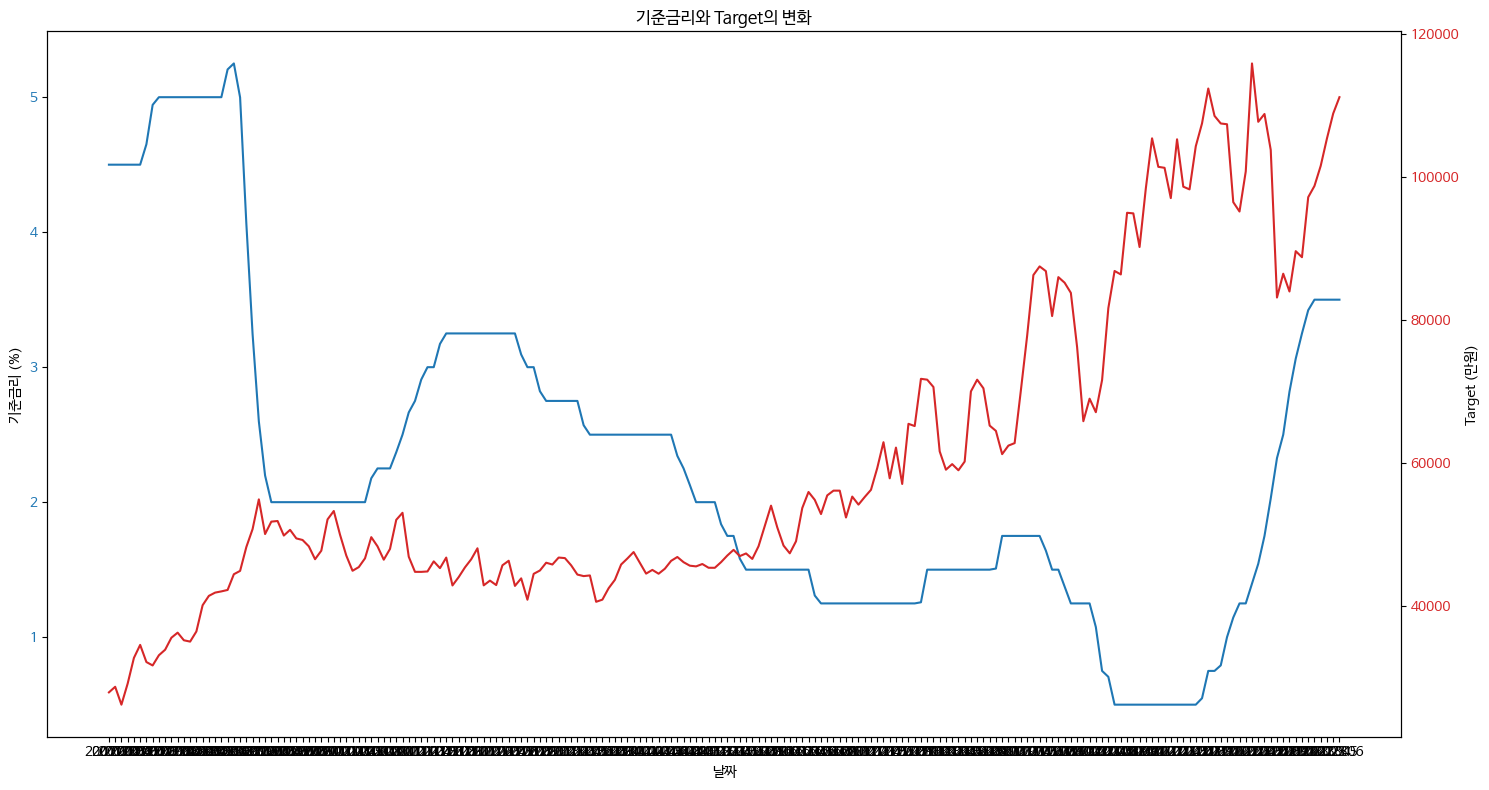

In [25]:
# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(15, 8))

# 기준금리를 첫 번째 축에 표시
ax1.plot(grouped_data['계약년월'], grouped_data['기준금리'], color='tab:blue', label='기준금리')
ax1.set_xlabel('날짜')
ax1.set_ylabel('기준금리 (%)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# target을 두 번째 축에 표시
ax2 = ax1.twinx()
ax2.plot(grouped_data['계약년월'], grouped_data['target'], color='tab:red', label='target')
ax2.set_ylabel('Target (만원)')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('기준금리와 Target의 변화')
plt.xticks(rotation=0)
fig.tight_layout()
plt.show()

In [26]:
grouped_data.tail(30)

,계약년월,target,기준금리,기준금리_이동평균,target_이동평균
168,202101,101374.351512,0.500000,0.500000,101692.806904
169,202102,101235.022109,0.500000,0.500000,102656.754175
170,202103,97003.194588,0.500000,0.500000,99870.856070
171,202104,105221.477218,0.500000,0.500000,101153.231305
172,202105,98599.783077,0.500000,0.500000,100274.818294
173,202106,98218.825353,0.500000,0.500000,100680.028549
174,202107,104250.153621,0.500000,0.500000,100356.254017
175,202108,107445.286260,0.547591,0.515864,103304.755078
176,202109,112323.323330,0.750000,0.599197,108006.254404
177,202110,108495.443524,0.750000,0.682530,109421.351038
